In [1]:
import pickle
from pathlib import Path
from tqdm.auto import tqdm, trange

from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_1samp
import numpy as np, pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
path2dir = Path('/work/magroup/hanzhan4/model_output/hcformer_pbulk')
with open(path2dir / 'baseline/baseline_test_ahr49sz0.pkl', 'rb') as f:
    baseline_test_output = pickle.load(f).numpy()
with open(path2dir / 'baseline/baseline_valid_ahr49sz0.pkl', 'rb') as f:
    baseline_valid_output = pickle.load(f).numpy()

with open(path2dir / 'hic1d2d/hic1d2d_test_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_test_output = pickle.load(f).numpy()
with open(path2dir / 'hic1d2d/hic1d2d_valid_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_valid_output = pickle.load(f).numpy()

# do not need to modify
with open(path2dir / 'test_expression.pkl', 'rb') as f:
    test_exp = pickle.load(f).numpy()

with open(path2dir / 'valid_expression.pkl', 'rb') as f:
    valid_exp = pickle.load(f).numpy()

In [3]:
baseline_test_output.shape, hic1d2d_test_output.shape, test_exp.shape

((4488, 240, 1), (4488, 240, 1), (4488, 240, 1))

In [4]:
shape = (6, 748, 240)
def fn(x):
    return x.reshape(6, 748, 240).transpose(1, 0, 2).reshape(748, 6 * 240)
corr_1d2d = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn(hic1d2d_test_output), fn(test_exp)))])
corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn(baseline_test_output), fn(test_exp)))])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
corr_1d2d.mean(), corr_baseline.mean()

(0.3792799557632494, 0.33470103897671794)

/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


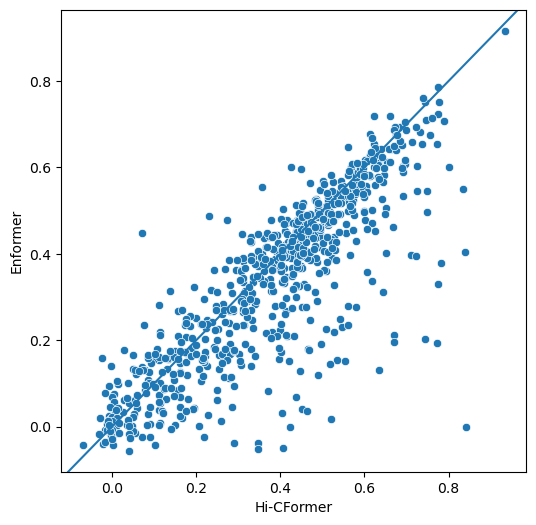

In [6]:
x, y = corr_1d2d, corr_baseline
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(ax=ax, x=x, y=y)
ax.axline((0, 0), slope=1)
ax.set(xlabel='Hi-CFormer', ylabel='Enformer')
plt.show()
plt.close('all')

In [7]:
path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC')
df_gene = pd.read_csv(path2dir / 'genes.tsv', sep='\t').iloc[2992:]
df_tfbs = pd.read_csv(path2dir / 'tfbs' / 'hit_r1000_dboth_thr0.csv.gz')
df_tfbs = df_tfbs[df_tfbs.gene_id.isin(df_gene.gene_id)]

In [8]:
df = df_tfbs.set_index(['gene_id', 'tf_name']).hit.unstack().fillna(0).astype(int).loc[df_gene.gene_id]

In [9]:
corr_diff = corr_1d2d - corr_baseline

In [10]:
x = corr_diff
y = df.values
df_test = pd.DataFrame([
    pearsonr(x, _)
    for _ in tqdm(y.T)
], index=df.columns)

  0%|          | 0/251 [00:00<?, ?it/s]

/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='statistic', ylabel='Count'>

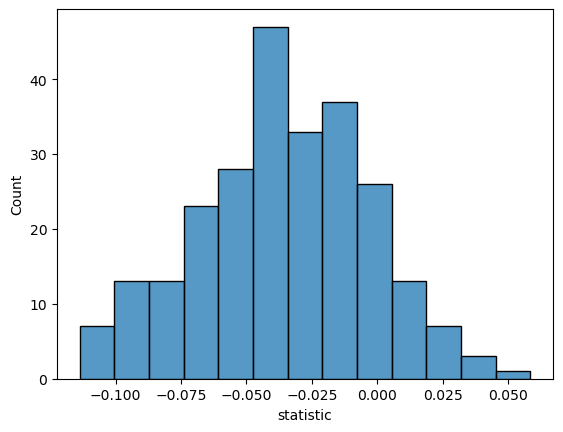

In [13]:
sns.histplot(df_test.statistic)

In [61]:
ttest_1samp(df_test.statistic, 0)

TtestResult(statistic=-17.361149055945024, pvalue=7.77136587075766e-45, df=250)

In [14]:
corr_diff = corr_1d2d + corr_baseline

In [15]:
x = corr_diff
y = df.values
df_test = pd.DataFrame([
    pearsonr(x, _)
    for _ in tqdm(y.T)
], index=df.columns)

  0%|          | 0/251 [00:00<?, ?it/s]

/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='statistic', ylabel='Count'>

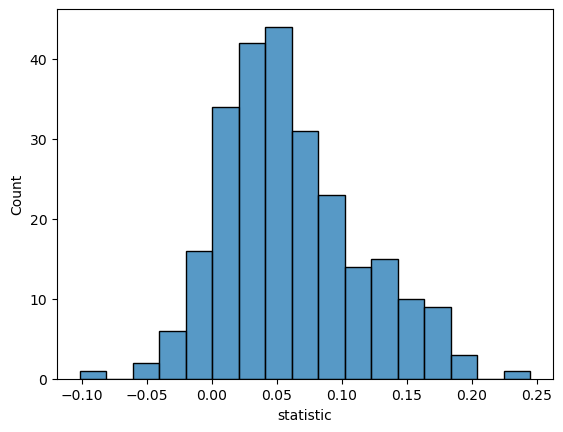

In [16]:
sns.histplot(df_test.statistic)

In [17]:
ttest_1samp(df_test.statistic, 0)

TtestResult(statistic=17.503842017462127, pvalue=2.519529372696703e-45, df=250)

In [23]:
mask = df_test.pvalue < 1e-3
print(mask.sum())
x = corr_diff
y = df.values[:, mask].mean(1)
pearsonr(x, y)

39


PearsonRResult(statistic=0.31401503837041367, pvalue=1.4014865118641746e-18)

/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/work/magroup/tianming/anaconda3/envs/SeqHiC2RNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


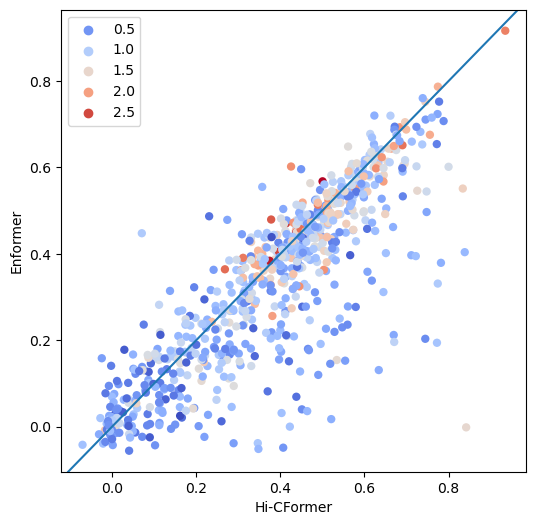

In [27]:
x, y = corr_1d2d, corr_baseline
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(ax=ax, x=x, y=y, hue=np.log1p(df.values[:, mask].mean(1)), edgecolor='none', palette='coolwarm')
ax.axline((0, 0), slope=1)
ax.set(xlabel='Hi-CFormer', ylabel='Enformer')
plt.show()
plt.close('all')